In [1]:
# Dependencies
%pylab inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.ticker as mtick
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Read In Data

In [2]:
filePath = "./Data/h1b_kaggle.csv"
df = pd.read_csv(filePath, header=0)

#### Drop unnecessary features

## Data Cleaning
+ Remove outliers 
+ Remove missing data

In [3]:
# Drop unnecessary features
try:
    df.drop(['Unnamed: 0', 'lon', 'lat', 'SOC_NAME'], axis=1, inplace=True)
except ValueError:
    print("Already deleted unnecessary features")
original_number_of_instances = len(df)

#### Drop instances with missing feature values

In [4]:
df.dropna(inplace=True)

In [5]:
instances_after_missing_dropped = len(df)
print("Before deletion: {} After Deletion : {} "
      .format(original_number_of_instances, instances_after_missing_dropped))

Before deletion: 3002458 After Deletion : 3002311 


#### Remove Outliers in the ___PREVAILING_WAGE___ feature
#### Change ___PREVAILING_WAGE___ values to _int_
#### Change ___YEAR___ values to _int_

In [6]:
# Remove outliers in wage
df2 = df[~(np.abs(df["PREVAILING_WAGE"] - df["PREVAILING_WAGE"].mean()) > (2 * df["PREVAILING_WAGE"].std()))]
def transform_to_int(x):
    return int(x)

df2['PREVAILING_WAGE'] = df2["PREVAILING_WAGE"].apply(transform_to_int)
df2['YEAR'] = df2["YEAR"].apply(transform_to_int)


#### Limit the outcomes in the target to :
+ CERTIFIED | CERTIFIED-WITHDRAWN | DENIED | WITHDRAWN

In [7]:
certified = df["CASE_STATUS"] == "CERTIFIED"
certified_withdrawn = df["CASE_STATUS"] == "CERTIFIED-WITHDRAWN"
denied = df["CASE_STATUS"] == "DENIED"
withdrawn = df["CASE_STATUS"] == "WITHDRAWN"

df2 = df2[certified | certified_withdrawn | denied | withdrawn]

#### Select 10,000 instances to sample. Using Sampling without replacement method of sampling

In [8]:
# df.take() uses positions to select instances
df3 = df2.take(np.random.permutation(len(df2)))[:5000]

In [9]:
len(df3)

5000

## Data Understanding and Description

## Data Preprocessing

In [10]:
df3[:5]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
63137,CERTIFIED,PATHSTONE HOLDINGS LLC,ASSOCIATE,N,47902,2016,"ATLANTA, GEORGIA"
1168942,CERTIFIED,INFOSYS LIMITED,TECHNICAL TEST LEAD - US,Y,81515,2015,"IRVING, TEXAS"
2618912,CERTIFIED,INFOSYS LIMITED,TECHNOLOGY LEAD - US,Y,81681,2012,"SAN FRANCISCO, CALIFORNIA"
2812563,CERTIFIED,INTONE NETWORKS INC,BUSINESS ANALYST,Y,47840,2011,"DES MOINES, IOWA"
2669045,CERTIFIED,"HEALTH HERO NETWORK, INC.",SENIOR SOFTWARE ENGINEER,Y,96126,2011,"PALO ALTO, CALIFORNIA"


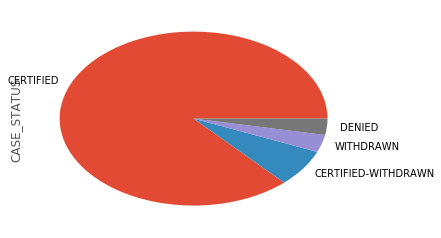

In [11]:
df3["CASE_STATUS"].value_counts().plot.pie()

### Encode the independent features

In [12]:
cols_list = list(df3.columns)
s = " + ".join([item for item in cols_list if item != "CASE_STATUS"])
print(s)

EMPLOYER_NAME + JOB_TITLE + FULL_TIME_POSITION + PREVAILING_WAGE + YEAR + WORKSITE


### Encode the Data

In [13]:
import patsy

In [16]:
X = df[["EMPLOYER_NAME", "JOB_TITLE", "FULL_TIME_POSITION", "PREVAILING_WAGE", "YEAR", "WORKSITE"]]

In [ ]:
X_enc = patsy.dmatrix(s, X, return_type='dataframe')

#### Split the Data you just encoded

## Classification Model

In [ ]:
## Sample 10 000 instances. 

## Evaluation of Classification model